In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
sns.set()

In [3]:
# importing the dataset

df = pd.read_excel('Data_Train.xlsx')
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [4]:
# The below stats show 'Power' column has 36 missing values but on closer observation of the dataset,
# we could find that there some entries stating 'null bhp' which should also be dealt while handling missing values
df.isnull().sum() 

Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

In [5]:
df.shape

(6019, 12)

### Changing the type of Mileage, Engine, Power columns from '*str* ' to ' *int* ' inorder to perform analysis

In [6]:
# Converting series data into String format

mileageStr = df.Mileage.to_string() 
power = df.Power.to_string()
engine = df.Engine.to_string()

In [7]:
# converting the format of Mileage. For example converting '26.6 km/kg' to '26.60'

pattern = re.compile(r'([\d]+\.\d+)|(NaN)')  # Using RegEx to identify patterns
match = pattern.finditer(mileageStr)

newMileage = []
for i in match:
    newMileage.append(float(i.group()))

df['Mileage'] = pd.Series(newMileage)

In [8]:
#len(df.loc[df['Mileage'] == 0]) 

In [9]:
# converting the format of Engine. For example converting '998 CC' to '998.0'

pattern = re.compile(r'([\d]+\s)(CC)|(NaN)')  # Using RegEx to identify patterns
match = pattern.finditer(engine)

newEngine = []

for i in match:
    if i.group(1) is not None:  
        newEngine.append(int(i.group(1)))   # converting the str values into int
    else:
        newEngine.append(i.group(1))        # NaN values can't be typecasted so appending without any modification

df['Engine'] = pd.Series(newEngine)
#df.head()

In [10]:
# converting the format of Power. For example converting '58.16 bhp' to '58.16'

pattern = re.compile(r'(\d+\.?\d+)\sbhp|(null\sbhp)|(NaN)')  # Using RegEx to identify patterns
match = pattern.finditer(power)

newPower = []

for i in match:
    if i.group(1) is not None:  
        newPower.append(float(i.group(1)))   # converting the str values into int
    else:
        newPower.append(i.group(1))        # NaN values can't be typecasted so appending without any modification

df['Power'] = pd.Series(newPower)
#df.head()

In [11]:
df.Power.isnull().sum()  # 'null bhp' entries have also been converted to null

143

### Removing Null values 

In [12]:
# Since its a large dataset containing over 6000 entries and we hardly have 200 
# Null values (just 0.03% of total data), we could remove those rows!

# Removing entries(rows) if all any of the columns(Engine,Power,Seats) are null.  

df.dropna(subset = ['Engine','Power','Seats','Mileage'], how = 'any', inplace = True)
df.shape   # 6019 entries reduced to 5874

(5872, 12)

In [13]:
df.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

### Understanding the correlation between numerical data

In [14]:
df.corr()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
Year,1.000000,-0.169369,0.285623,-0.068045,0.014531,0.007833,0.299475
Kilometers_Driven,-0.169369,1.000000,-0.060608,0.093030,0.033490,0.083072,-0.008249
Mileage,0.285623,-0.060608,1.000000,-0.637258,-0.538844,-0.331576,-0.341652
Engine,-0.068045,0.093030,-0.637258,1.000000,0.866301,0.401116,0.658047
Power,0.014531,0.033490,-0.538844,0.866301,1.000000,0.101460,0.772843
Seats,0.007833,0.083072,-0.331576,0.401116,0.101460,1.000000,0.055547
Price,0.299475,-0.008249,-0.341652,0.658047,0.772843,0.055547,1.000000


From the above data, we could interpret that `Year` , `Engine` , `Power` and `Seats` have a **Positive** correlation with price. To be specific, **Engine** and **Power** have strong linear correlation with price.

### Performing EDA to get more insights of data

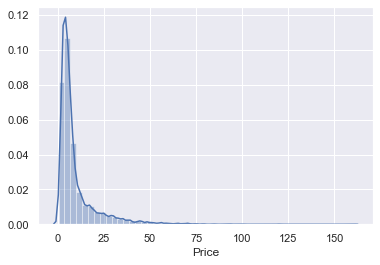

In [15]:
sns.distplot(df.Price,kde = True,hist = True)     # Histogram of Price

From the histogram of Price, we could infer the following
* The distribution of Price is **right skewed** with considerable number of *Outliers* along the right tail.
* The region from 1 to 25 (in Lakhs) has more density. This shows us that most of cars are priced in this range.

[Text(0, 0.5, 'Mean Price (in Lakhs)'),
 Text(0.5, 0, 'Location'),
 Text(0.5, 1.0, 'Mean Price of cars in each Locality')]

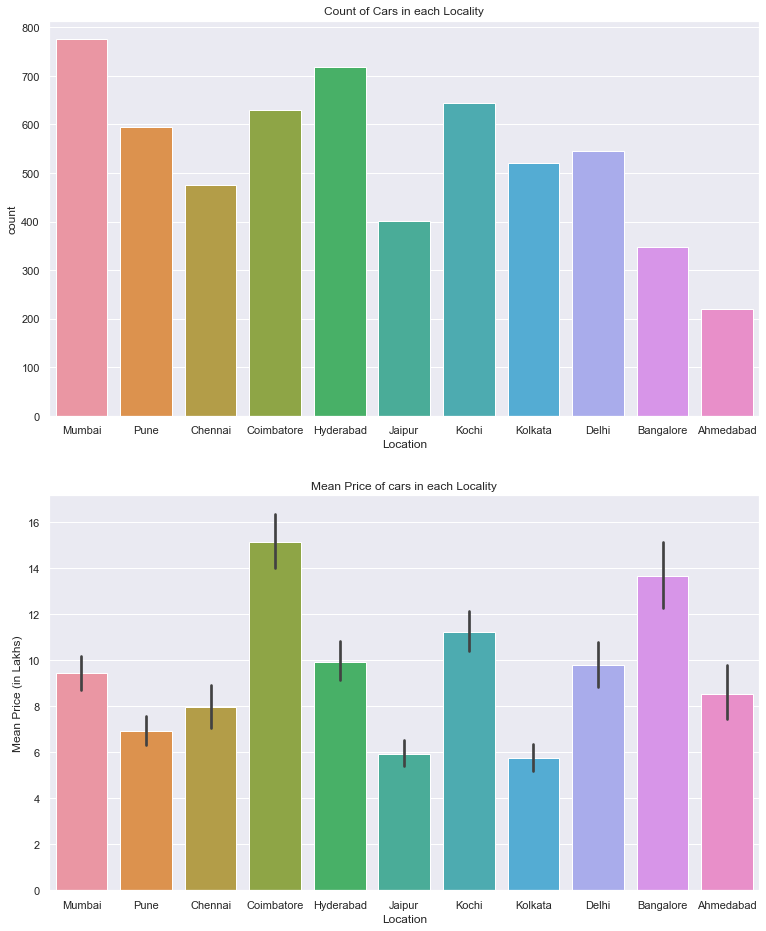

In [16]:
# plot to show count of cars in each location
plt.figure(figsize = (28,16))

plt.subplot(2,2,1)
count = sns.countplot(x = df['Location'], data = df)
count.set(xlabel = 'Location', title = 'Count of Cars in each Locality')

plt.subplot(2,2,3)
count = sns.barplot(x = 'Location', y = 'Price', data =df)
count.set(xlabel = 'Location',ylabel = 'Mean Price (in Lakhs)', title = 'Mean Price of cars in each Locality')

From the barplot,
* The mean price of cars sold in **Coimbatore** is higher than the other cities.
* The mean price of cars sold in **Kolkata** is the least of all cities.

In [17]:
#df.groupby('Location')['Price'].mean()

[Text(0, 0.5, 'Mean Price (in Lakhs)'),
 Text(0.5, 0, 'Owner Type'),
 Text(0.5, 1.0, 'Mean Price for different Ownership of Cars')]

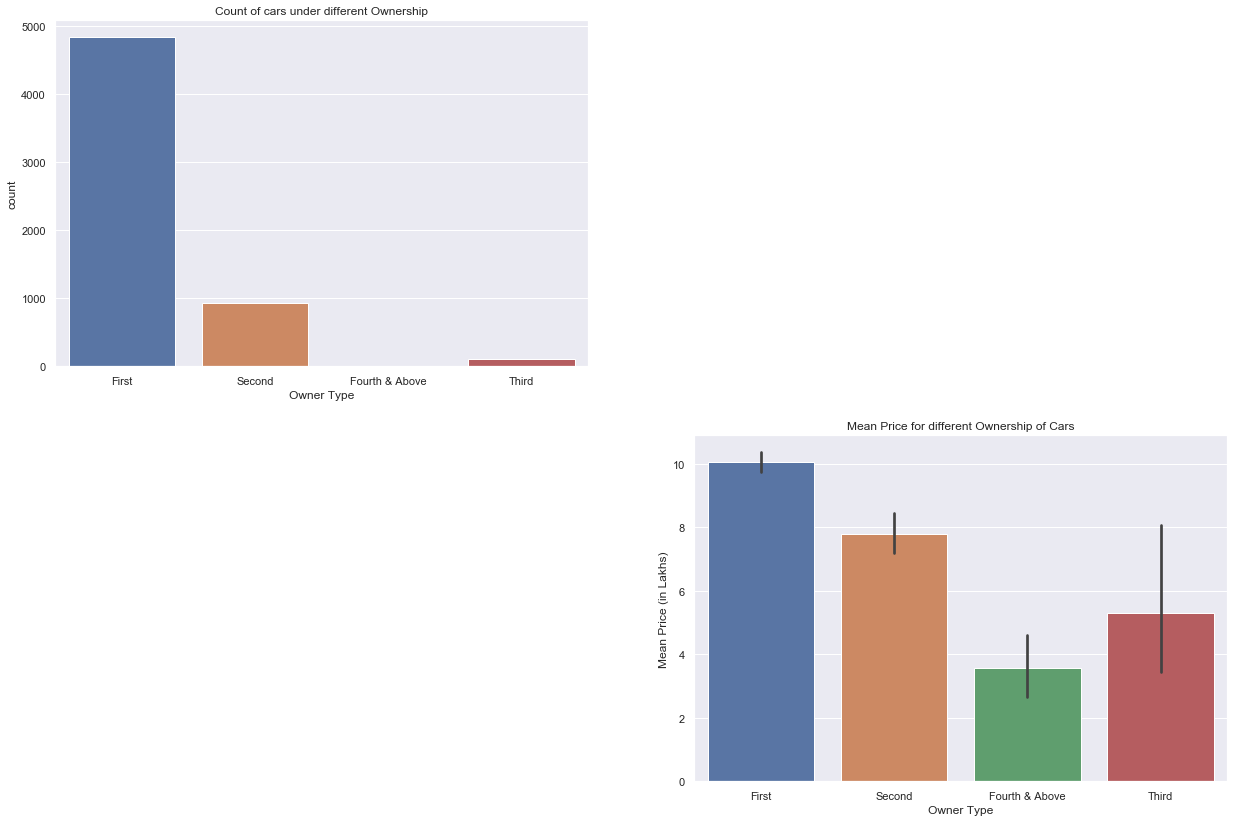

In [18]:
# Insights about Owner type's influence on Cars
plt.figure(figsize = (21,14))

plt.subplot(2,2,1)
ct = sns.countplot(x = df['Owner_Type'], data = df)
ct.set(xlabel = 'Owner Type', title = 'Count of cars under different Ownership')

plt.subplot(2,2,4)
bar = sns.barplot(x = 'Owner_Type', y = 'Price', data =df)
bar.set(xlabel = 'Owner Type', ylabel = 'Mean Price (in Lakhs)', title = 'Mean Price for different Ownership of Cars')

1.From the countplot,
* Most of the cars for sale are new cars (First Owned cars).
* There are very less number of cars in Fourth & Above Ownership

2.From the Barplot,
* As expected the mean Price of First Owner cars are relatively high, and that of Fourth & above are priced lesser.

[Text(0, 0.5, 'Mean Price (in Lakhs)'),
 Text(0.5, 0, 'Type of Transmission'),
 Text(0.5, 1.0, 'Mean Price for different Transmission of Cars')]

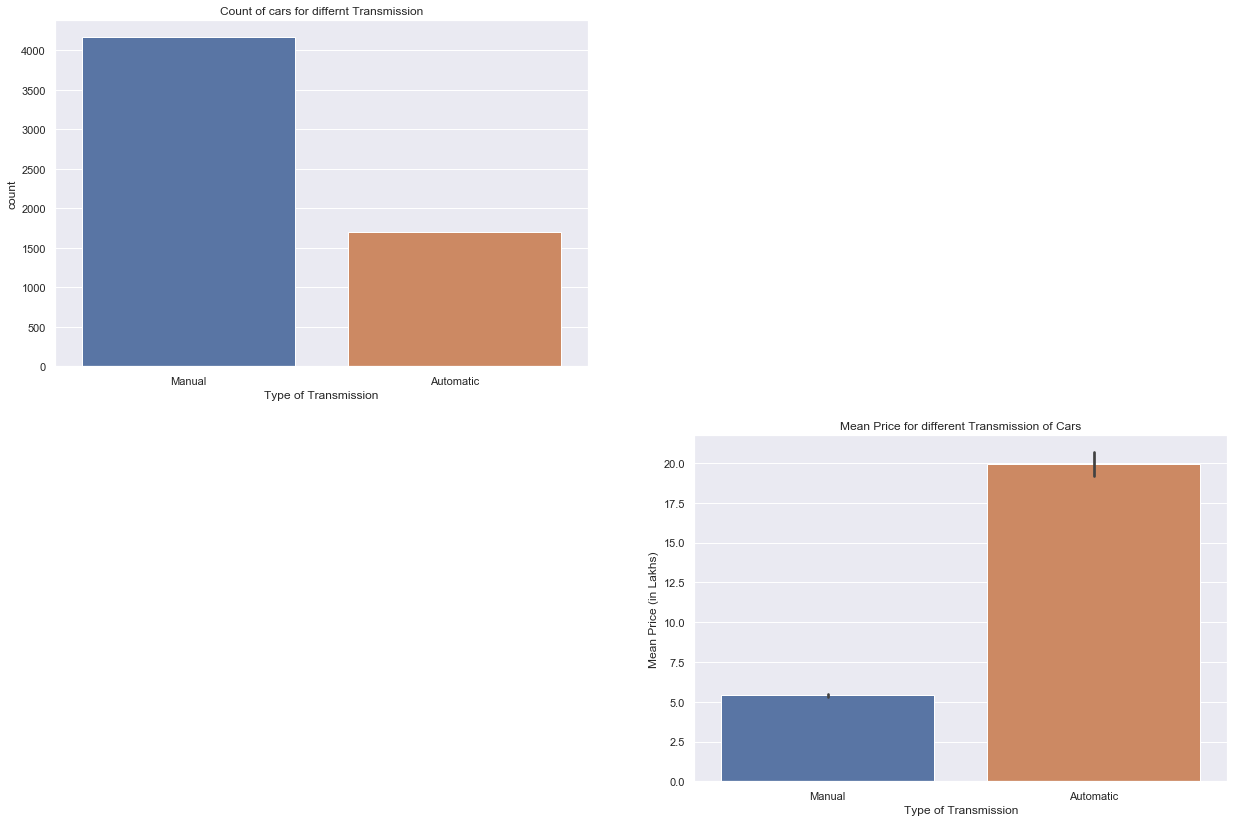

In [19]:
# Insights about Type of Transmission's influence on Cars
plt.figure(figsize = (21,14))

plt.subplot(2,2,1)
ct = sns.countplot(x = df['Transmission'], data = df)
ct.set(xlabel = 'Type of Transmission', title = 'Count of cars for differnt Transmission')

plt.subplot(2,2,4)
bar = sns.barplot(x = 'Transmission', y = 'Price', data =df)
bar.set(xlabel = 'Type of Transmission', ylabel = 'Mean Price (in Lakhs)', title = 'Mean Price for different Transmission of Cars')

From the Countplot,
* There are more number of Manual Cars than Automatic.


From the Barplot,
* The Mean Price of Automatic cars is close to 20 Lakhs and that of Manual is just over 5 Lakhs.
* The Mean Price of Automatic cars are way more higher than that of Manual cars.


[Text(0, 0.5, 'Mean Price (in Lakhs)'),
 Text(0.5, 0, 'Type of Fuel'),
 Text(0.5, 1.0, 'Mean Price for different Fuel types')]

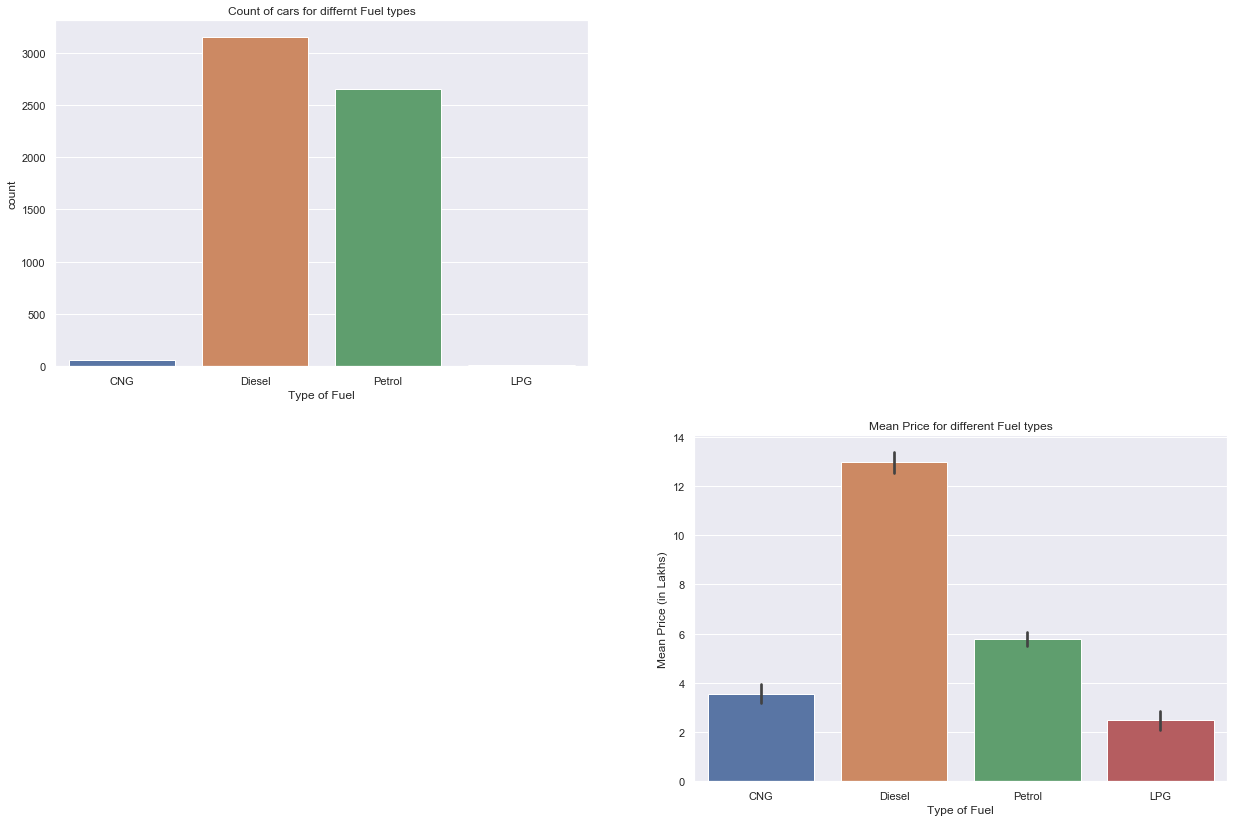

In [20]:
# Insights about Fuel Type's influence on Cars
plt.figure(figsize = (21,14))

plt.subplot(2,2,1)
ct = sns.countplot(x = df['Fuel_Type'], data = df)
ct.set(xlabel = 'Type of Fuel', title = 'Count of cars for differnt Fuel types')

plt.subplot(2,2,4)
bar = sns.barplot(x = 'Fuel_Type', y = 'Price', data =df)
bar.set(xlabel = 'Type of Fuel', ylabel = 'Mean Price (in Lakhs)', title = 'Mean Price for different Fuel types')

From the Countplot,
* The number of Diesel Cars are higher than other cars.
* The number of LPG cars are very less.

From the Barplot,
* Mean Price of Diesel Cars are comparitively higher(over 12 Lakhs)

[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'Engine Displacement (in CC)'),
 Text(0.5, 1.0, 'ENGINE DISPLACEMENT vs PRICE')]

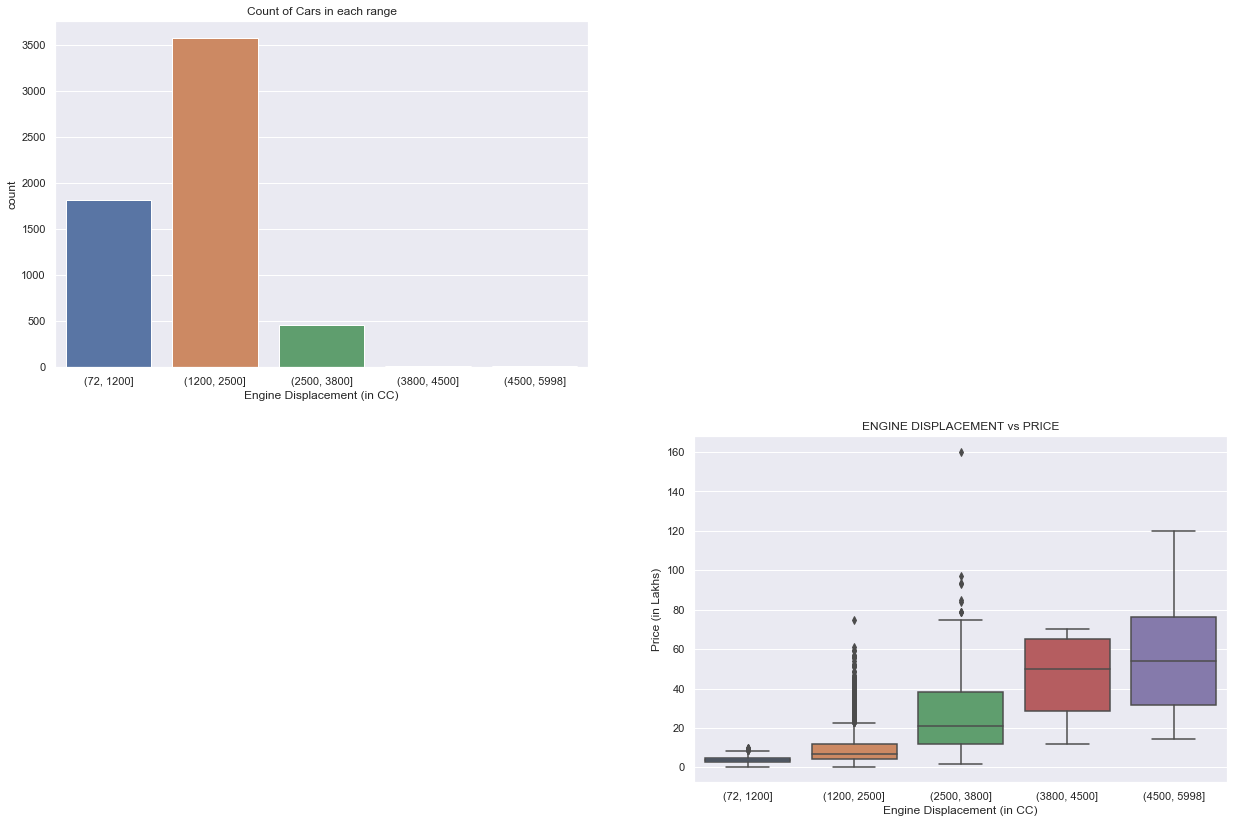

In [21]:
# Stratifying the data to know the price of cars with accordance to Engine Capacity 

# Creating a temporary DataFrame
tempDf = pd.DataFrame()     

# pd.cut() categorizes each engine value to fit in the specified cut range
tempDf['Engine'] = pd.cut(df.Engine, [72,1200,2500,3800,4500,5998])   
tempDf['Price'] = df['Price'] 

# plotting 
plt.figure(figsize = (21,14))
plt.subplot(2,2,1)
count = sns.countplot(x = tempDf['Engine'], data = tempDf)
count.set(xlabel = 'Engine Displacement (in CC)', title = 'Count of Cars in each range')

plt.subplot(2,2,4)
fig = sns.boxplot(x="Engine", y="Price", data=tempDf)
fig.set(xlabel = 'Engine Displacement (in CC)', ylabel = 'Price (in Lakhs)',title = 'ENGINE DISPLACEMENT vs PRICE')

1.Inferences from the Countplot of Engine,
* Most of the cars(more than 3500) fall in the Engine Displacement range of **1200cc - 2500cc**.
* Number of cars with with Engine Displacement over 3800cc are **meagre** (very less in number).


2.Inferences from Boxplot of Engine vs Price
* As expected the cars with higher Engine Displacement(**4500cc-5998cc**) are Priced higher comparitively.
* As the Engine capacity increases the **median** of price also increases. 
* There are **many outliers** present in engine capacity range of 1200cc-2500cc.

[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'Power (in bhp)'),
 Text(0.5, 1.0, 'POWER vs PRICE')]

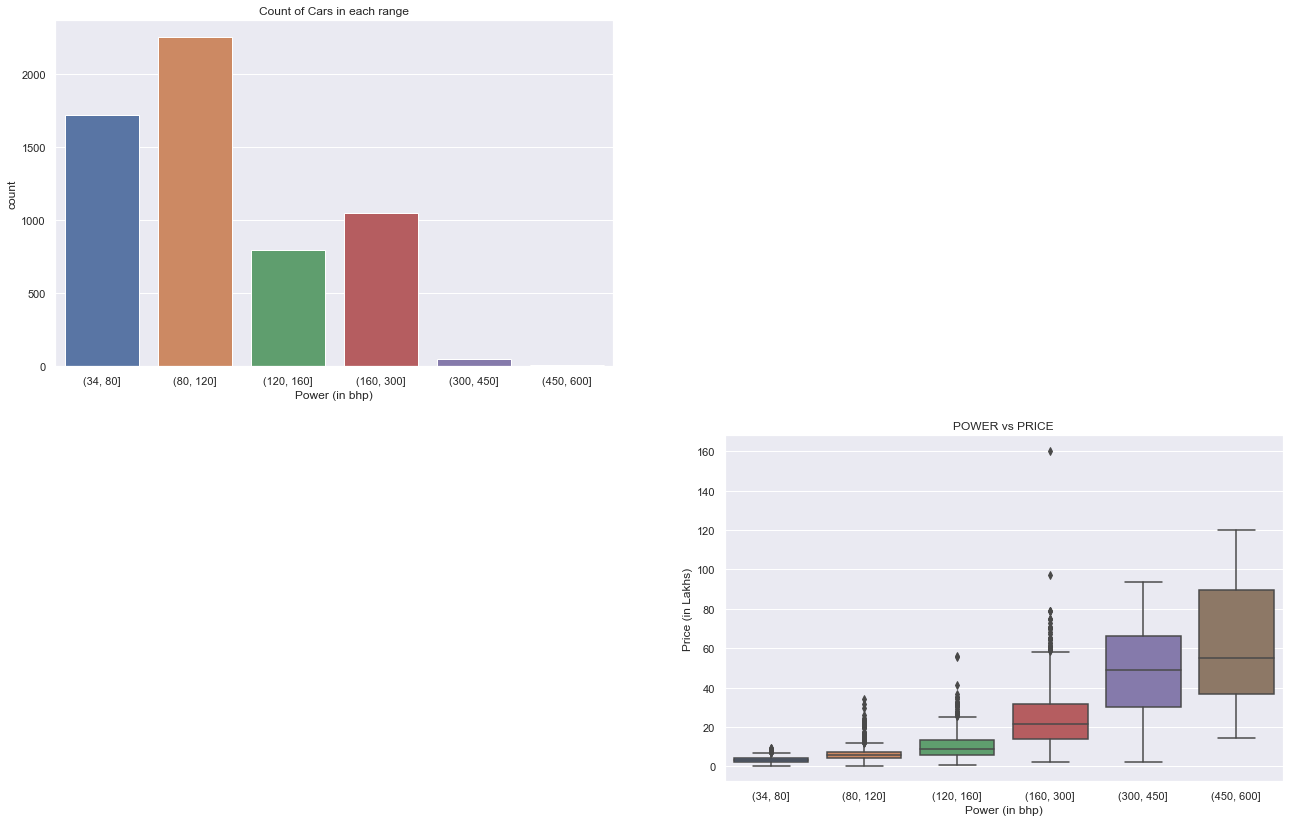

In [22]:
tempDf['Power'] = pd.cut(df.Power, [34, 80, 120, 160, 300, 450, 600])   

# plotting 
plt.figure(figsize = (22,14))
plt.subplot(2,2,1)
count = sns.countplot(x = tempDf['Power'], data = tempDf)
count.set(xlabel = 'Power (in bhp)', title = 'Count of Cars in each range')

plt.subplot(2,2,4)
fig = sns.boxplot(x='Power', y = 'Price', data=tempDf)
fig.set(xlabel = 'Power (in bhp)', ylabel = 'Price (in Lakhs)',title = 'POWER vs PRICE')


1.Inferences from the Countplot of Price,
* Most of cars(more than 2000) have the power between **80-120bhp**.
* Similarly number of cars over **300 bhp** are meagre. 

2.Inferences from Boxplot of Power vs Price

* As expected the cars with higher Power(450bhp-600bhp) are Priced higher comparitively.
* As the Power increases the median of price also increases in each range.
* There are a few outliers as well.

[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'YEAR vs PRICE')]

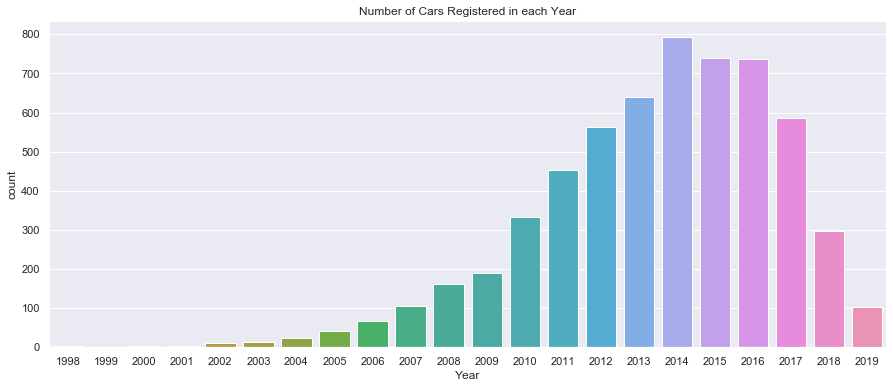

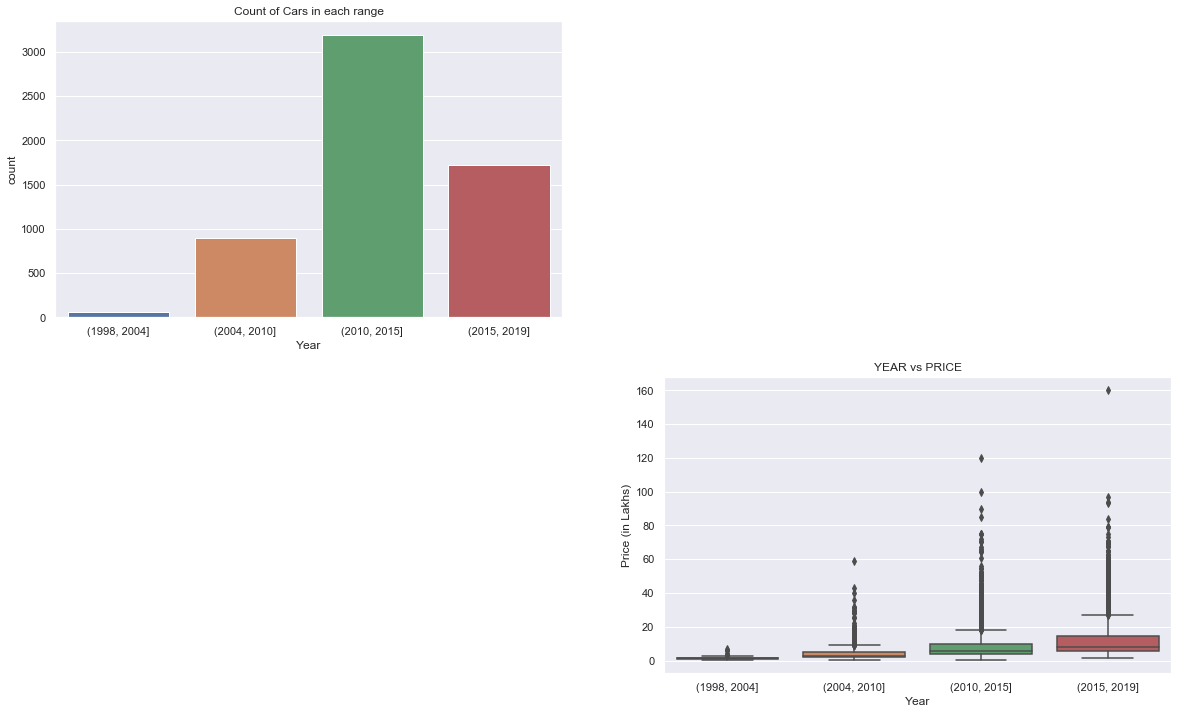

In [23]:
# plot to show the number of cars registered in each year
plt.figure(figsize = (15,6))
count1 = sns.countplot(x = df['Year'], data = df).set_title('Number of Cars Registered in each Year')


# stratification
tempDf['Year'] = pd.cut(df.Year, [1998,2004,2010,2015,2019])   

# plotting 
plt.figure(figsize = (20,12))

plt.subplot(2,2,1)
count = sns.countplot(x = tempDf['Year'], data = tempDf)
count.set(xlabel = 'Year', title = 'Count of Cars in each range')


plt.subplot(2,2,4)
fig = sns.boxplot(x='Year', y = 'Price', data=tempDf)
fig.set(xlabel = 'Year', ylabel = 'Price (in Lakhs)',title = 'YEAR vs PRICE')

1.From the Countplot of Years,
* Most of the cars have been registered between the years 2010-2015, followed by 2015-2019.
* 1998-2004 is the period with least number of cars registered.

2.Inference from the barplot,
* Year also has a positive linear correlation with price but there are many outliers in the data.

[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'Mileage (kmpl or km/kg)'),
 Text(0.5, 1.0, 'MILEAGE vs PRICE')]

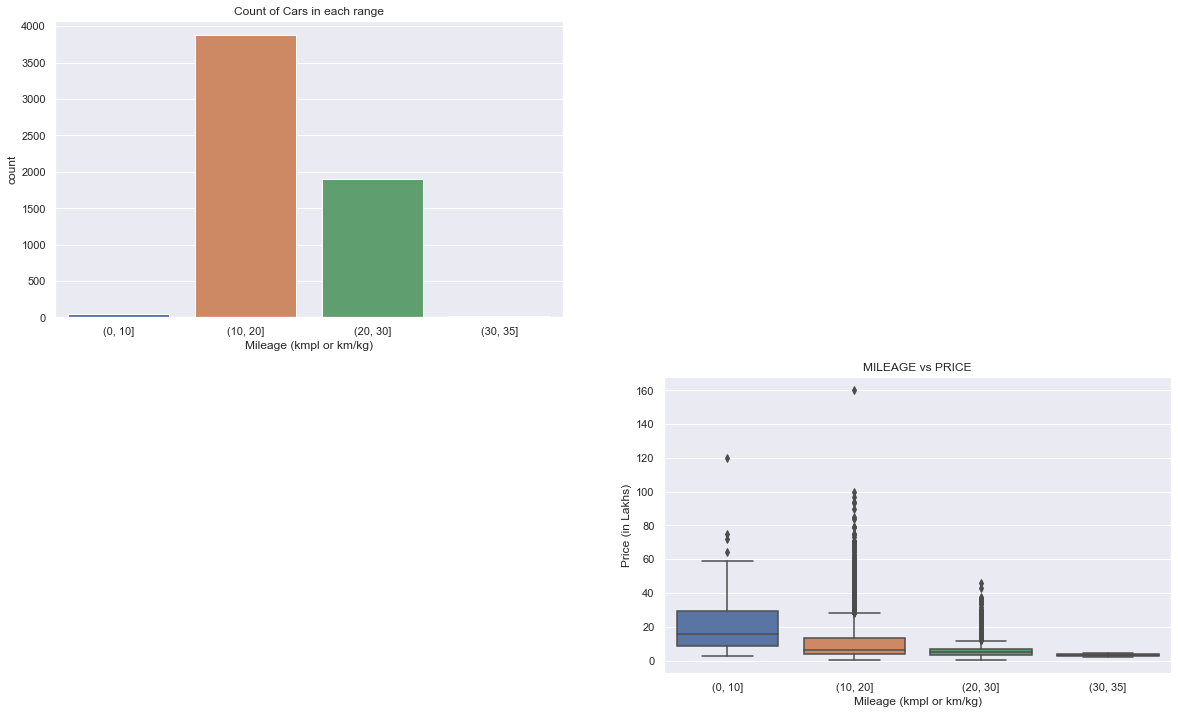

In [24]:
tempDf['Mileage'] = pd.cut(df.Mileage, [0,10,20,30,35])   

# plotting 
plt.figure(figsize = (20,12))

plt.subplot(2,2,1)
count = sns.countplot(x = tempDf['Mileage'], data = tempDf)
count.set(xlabel = 'Mileage (kmpl or km/kg)', title = 'Count of Cars in each range')


plt.subplot(2,2,4)
fig = sns.boxplot(x='Mileage', y = 'Price', data=tempDf)
fig.set(xlabel = 'Mileage (kmpl or km/kg)', ylabel = 'Price (in Lakhs)',title = 'MILEAGE vs PRICE')

1.Inferences from the countplot,
* Most of the cars have mileage between 10kmpl - 20kmpl
* Very less number of cars have mileage which less than 10kmpl or greater than 30kmpl

2.Inferences from Boxplot,
* There is a **Negative Correlation** between Price and Mileage. As a result all the expensive cars have very less mileage.


[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'KILOMETERS DRIVEN'),
 Text(0.5, 1.0, 'KILOMETERS DRIVEN vs PRICE')]

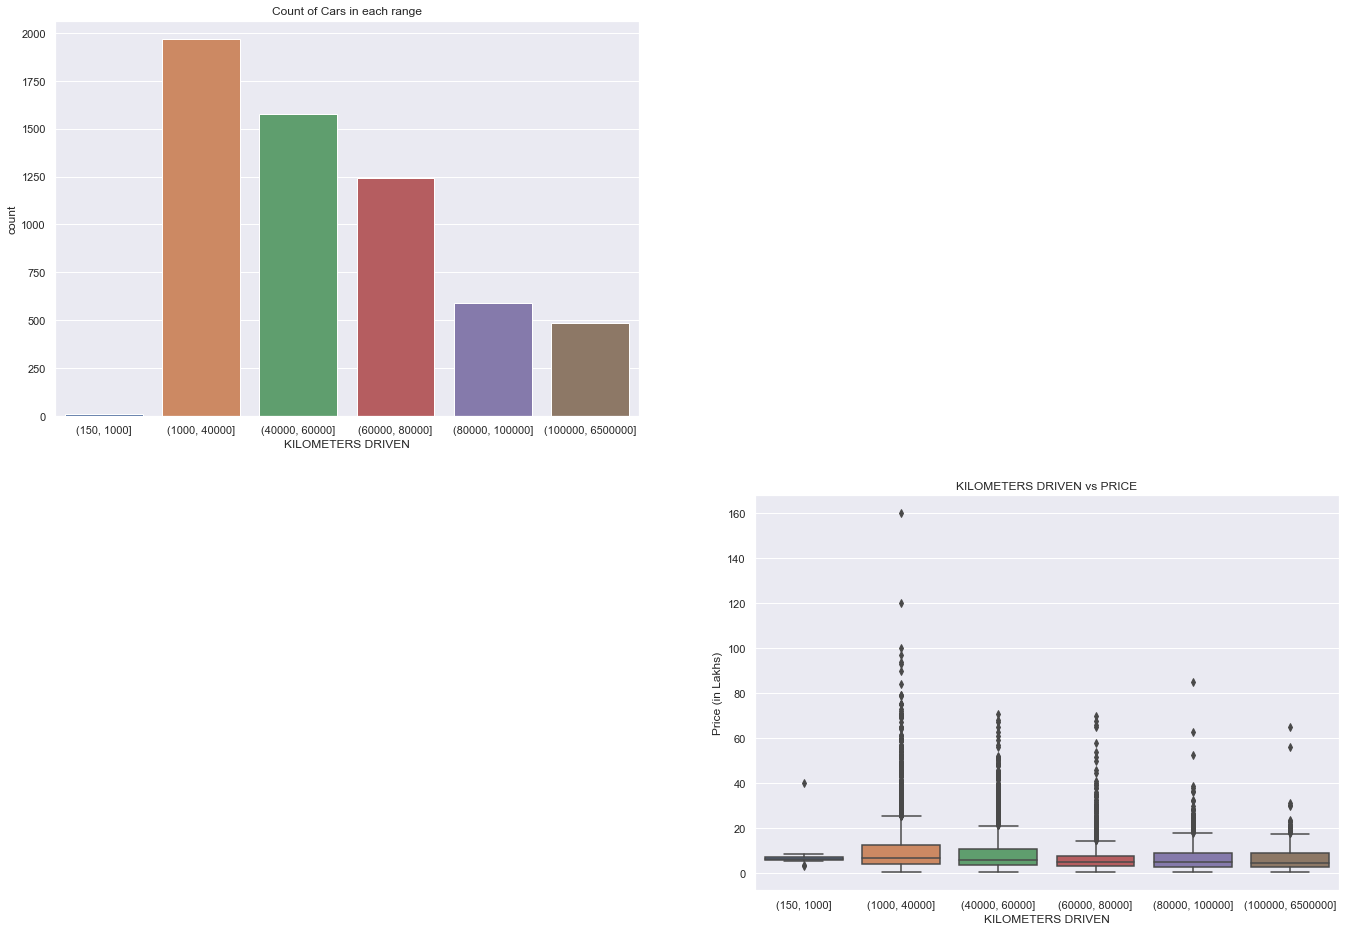

In [25]:
tempDf['Kilometers_Driven'] = pd.cut(df.Kilometers_Driven, [150,1000,40000,60000,80000,100000,6500000])   

# plotting 
plt.figure(figsize = (23,16))

plt.subplot(2,2,1)
count = sns.countplot(x = tempDf['Kilometers_Driven'], data = tempDf)
count.set(xlabel = 'KILOMETERS DRIVEN', title = 'Count of Cars in each range')


plt.subplot(2,2,4)
fig = sns.boxplot(x='Kilometers_Driven', y = 'Price', data=tempDf)
fig.set(xlabel = 'KILOMETERS DRIVEN', ylabel = 'Price (in Lakhs)',title = 'KILOMETERS DRIVEN vs PRICE')

1.Inferences from Countplot,

* Most of the cars have been driven upto a range of **1000kms - 4000kms**
* The count of cars in the range, decreases as the number of kilometeres driven increases.


2.Inferences from Barplot,
* There are many outliers in the data.
* On closer observation, we  could infer that the **Inter Quartile Range(IQR)** for the Price decreases as the Kilometers Driven increases.
* Thus, there is a **Negative Correlation**.

[Text(0, 0.5, 'Price (in Lakhs)'),
 Text(0.5, 0, 'Seats'),
 Text(0.5, 1.0, 'Seat Count vs PRICE')]

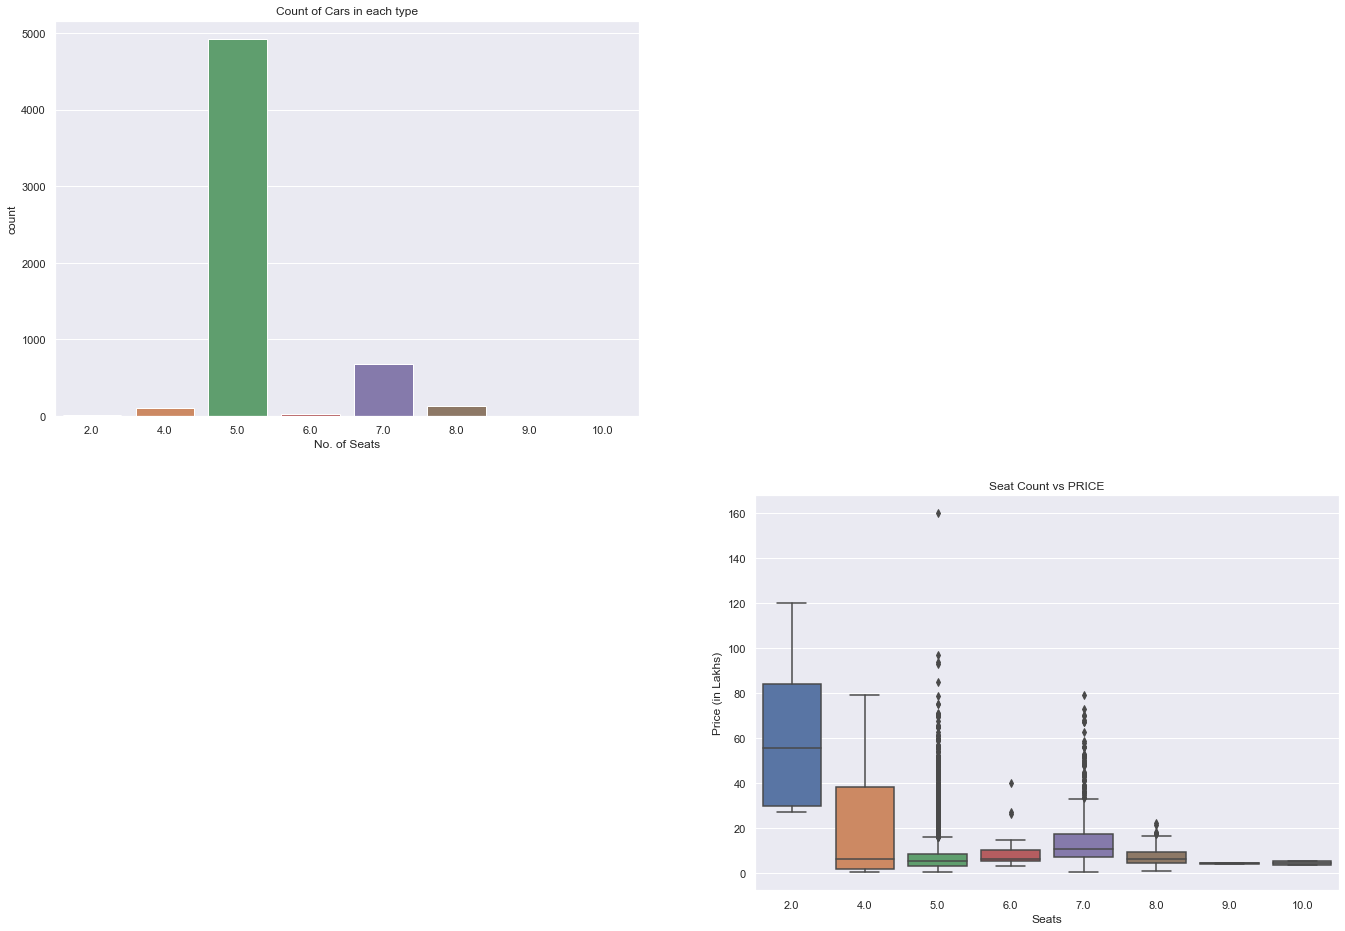

In [26]:
# plot to show the number of cars registered corresponding to Seat count


plt.figure(figsize = (23,16))

plt.subplot(2,2,1)
count = sns.countplot(x = df['Seats'], data = df)
count.set(xlabel = 'No. of Seats', title = 'Count of Cars in each type')

plt.subplot(2,2,4)
fig = sns.boxplot(x='Seats', y = 'Price', data = df)
fig.set(xlabel = 'Seats', ylabel = 'Price (in Lakhs)',title = 'Seat Count vs PRICE')

1.Inferences from the countplot,
* Most of cars in the given data are **5 Seaters**.
* 9 and 10 Seaters are very less in number.


2.Inferences from the barplot,
* 2 Seaters(Coupe) are the most expensive cars with IQR approximately between 30-85 Lakhs.
* Most of the Outliers are from the 5 Seater cars.

### Handling categorical variables by performing Label encoding

In [27]:
# Label Encoding all categorical data !

label_encoder = LabelEncoder()
df['Transmission'] = label_encoder.fit_transform(df['Transmission'])
df['Owner_Type'] = label_encoder.fit_transform(df['Owner_Type'])
df['Fuel_Type'] = label_encoder.fit_transform(df['Fuel_Type'])
df['Location'] = label_encoder.fit_transform(df['Location'])


#df.head()


### Scaling Kilometers_Driven column using MinMaxScaler

In [28]:
scaler = MinMaxScaler()                                 # Instantiating MinMaxScaler class and creating a scaler object.
df['Kilometers_Driven'] = scaler.fit_transform(df[['Kilometers_Driven']])  # scales down all values to a range of (0,1).
df.tail()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
6014,Maruti Swift VDI,4,2014,0.004184,1,1,0,28.40,1248.0,74.0,5.0,4.75
6015,Hyundai Xcent 1.1 CRDi S,6,2015,0.015359,1,1,0,24.40,1120.0,71.0,5.0,4.00
6016,Mahindra Xylo D4 BSIV,6,2012,0.008435,1,1,2,14.00,2498.0,112.0,8.0,2.90
6017,Maruti Wagon R VXI,8,2013,0.007051,3,1,0,18.90,998.0,67.1,5.0,2.65
6018,Chevrolet Beat Diesel,5,2011,0.007205,1,1,0,25.44,936.0,57.6,5.0,2.50


### Train Test Split

In [29]:
X = df[['Location','Year','Kilometers_Driven','Fuel_Type','Transmission','Owner_Type','Mileage', 'Engine', 'Power','Seats']]
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

###  Applying Regression Algorithms

In [30]:
r2_score = {}  # Holds r2 score of each model

In [31]:
# 1. Applying Linear Reression
linreg = LinearRegression().fit(X_train, y_train)
print('R-squared score (train): {:.3f}'
     .format(linreg.score(X_train, y_train))) #R-squared score (test): 0.693
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
r2_score['Linear Regressor'] = round(linreg.score(X_test, y_test), 3)  # rounding off to 3 decimal places

R-squared score (train): 0.695
R-squared score (test): 0.714


In [32]:
# tst = [[2011,0.007051,0,18.20,1199.0,88.70,5.0]]
# linreg.predict((tst))

In [33]:
# 2. Applying KNN Reressor
knnreg = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)
print('R-squared score (train): {:.3f}'
     .format(knnreg.score(X_train, y_train)))  
print('R-squared score (test): {:.3f}'
     .format(knnreg.score(X_test, y_test)))  
r2_score['KNN Regressor'] = round(knnreg.score(X_test, y_test), 3)  # rounding off to 3 decimal places

R-squared score (train): 0.870
R-squared score (test): 0.860


In [34]:
# tst = [[2013,0.006231,1,0,2,15.20,1968.0,140.80,5.0]]
# knnreg.predict((tst))

In [35]:
# 3. Applying Gradient Boosing Regressor
gb_reg = GradientBoostingRegressor(learning_rate=0.45).fit(X_train, y_train)
print('R-squared score (train): {:.3f}'.format(gb_reg.score(X_train, y_train)))     
print('R-squared score (test): {:.3f}'.format(gb_reg.score(X_test, y_test))) 
r2_score['Gradient Boosting Regressor'] = round(gb_reg.score(X_test, y_test), 3)  # rounding off to 3 decimal places

R-squared score (train): 0.977
R-squared score (test): 0.932


In [36]:
# tst = [[2010,0.011051,0,1,0,26.60,998.0,58.16,5.0]]
# clf.predict((tst))

In [37]:
# from sklearn.model_selection import GridSearchCV
# grid_values = {'n_estimators': [1, 10, 5, 15, 25,30, 40],'max_depth': [1,2,3,4,6],'max_features':[2,4,6,7,9]}

# default metric to optimize over grid parameters: accuracy
# grid_clf_acc = GridSearchCV(rf_reg, param_grid = grid_values)
# grid_clf_acc.fit(X_train, y_train)
# y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

# print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

In [38]:
# 4. Applying Random Forest Regressor
rf_reg = RandomForestRegressor().fit(X_train, y_train)
print('R-squared score (train): {:.3f}'.format(rf_reg.score(X_train, y_train)))     
print('R-squared score (test): {:.3f}'.format(rf_reg.score(X_test, y_test)))
r2_score['Random Forest Regressor'] = round(rf_reg.score(X_test, y_test), 3)  # rounding off to 3 decimal places

R-squared score (train): 0.983
R-squared score (test): 0.906


In [39]:
# tst = [[4,2014,0.004184,1,1,0,28.40,1248.0,74.0,5.0]]
# knnreg.predict(tst)
# #gb_reg.predict(tst)

### Error metrics for each model

In [40]:
for model,score in r2_score.items():
    print('R-Squared score(test data) for {} model is {}'.format(model, score))

R-Squared score(test data) for Linear Regressor model is 0.714
R-Squared score(test data) for KNN Regressor model is 0.86
R-Squared score(test data) for Gradient Boosting Regressor model is 0.932
R-Squared score(test data) for Random Forest Regressor model is 0.906


In [44]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(knnreg,X_test,y_test)

array([0.73618945, 0.80181726, 0.84908198, 0.71485746, 0.74850078])